Using downloaded and verified file: ./pneumoniamnist_224.npz
Using downloaded and verified file: ./organamnist_224.npz


100%|██████████| 1091112502/1091112502 [01:53<00:00, 9621397.47it/s] 


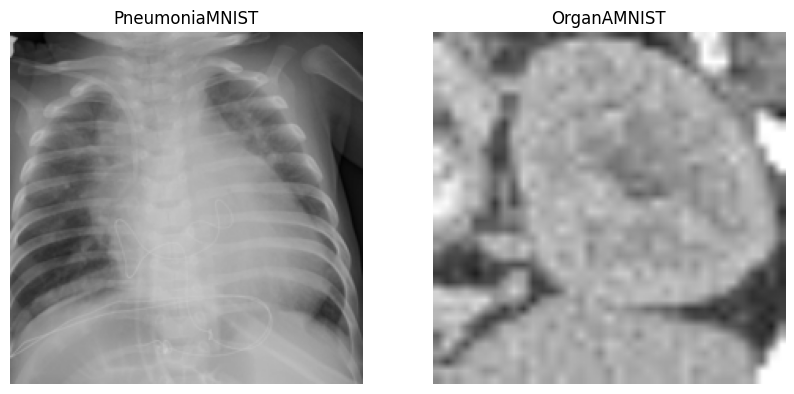

In [31]:
from medmnist import PneumoniaMNIST, OrganAMNIST, DermaMNIST, INFO
import matplotlib.pyplot as plt

# load dataset
pneumonia_data = PneumoniaMNIST(root='./', split='test', size=224,transform=None, download=True, as_rgb=True)
organ_data = OrganAMNIST(root='./', split='test', size=224,transform=None, download=True, as_rgb=True)
derma_data = DermaMNIST(root='./', split='test', size=224,transform=None, download=True, as_rgb=True)

# show images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(pneumonia_data[0][0])
plt.title('PneumoniaMNIST')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(organ_data[0][0])
plt.title('OrganAMNIST')
plt.axis('off')
plt.show()


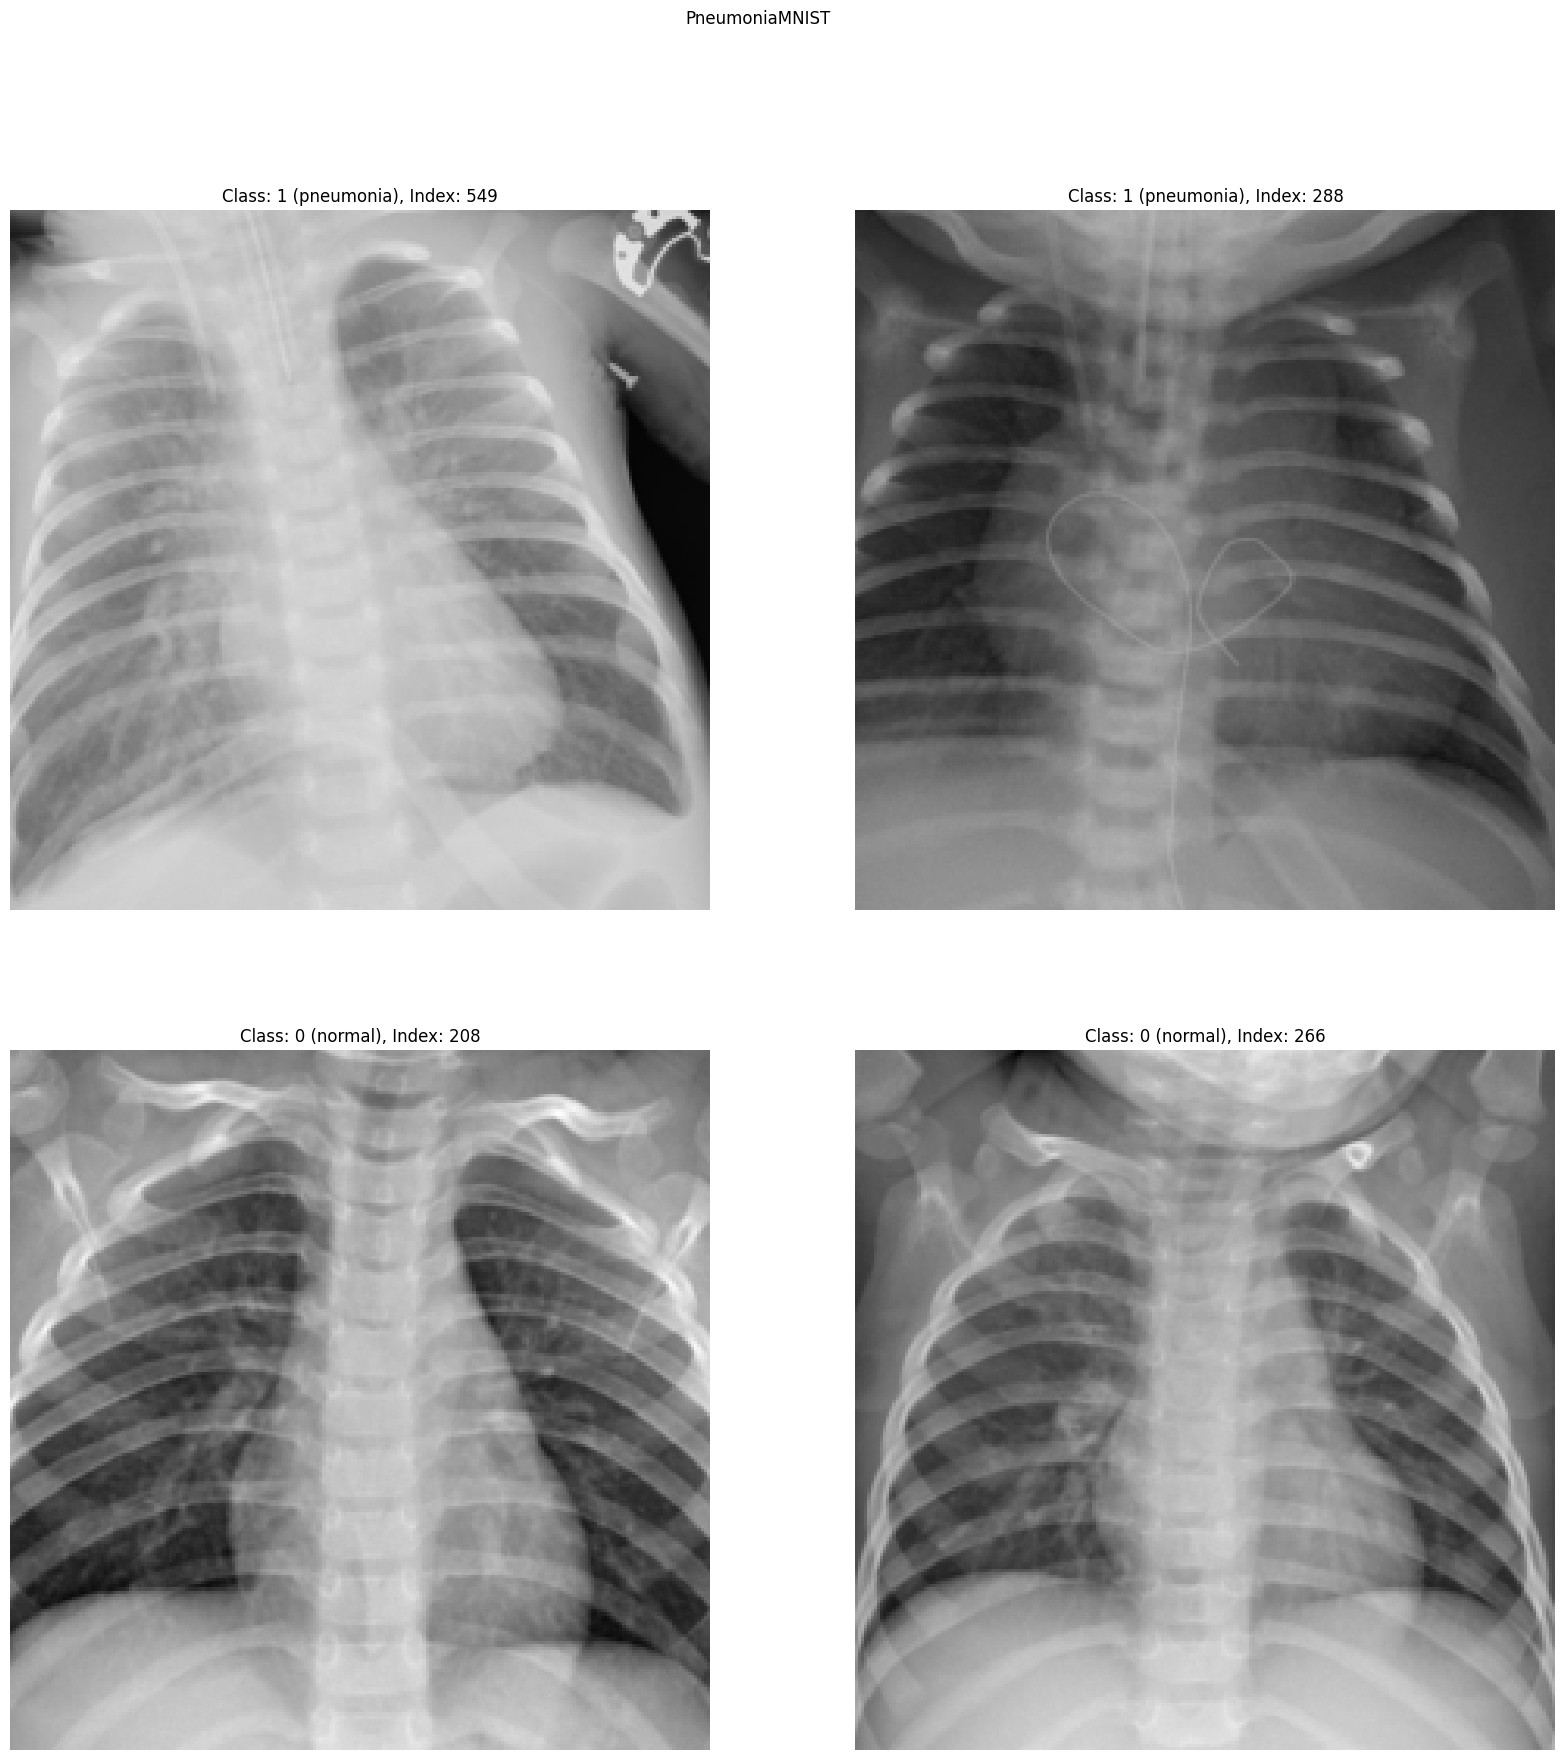

In [30]:
import numpy as np

def PlotFunction(data, title):
    fig, axs = plt.subplots(2, 2, figsize=(20, 20))
    labels = INFO[title.lower()]['label']
    fig.suptitle(title)

    imgIdx = np.random.randint(0, len(data), size=4)
    for i, idx in enumerate(imgIdx):
        axs[i//2, i%2].imshow(data[idx][0])
        axs[i//2, i%2].set_title(f'Class: {data[idx][1][0]} ({labels[str(data[idx][1][0])]}), Index: {idx}')
        axs[i//2, i%2].axis('off')

    plt.show()

PlotFunction(pneumonia_data, 'PneumoniaMNIST')

In [23]:
#INFO['organamnist']
labels = INFO['organamnist']['label']
print(labels)
print(labels['0'])

{'0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart', '4': 'kidney-left', '5': 'kidney-right', '6': 'liver', '7': 'lung-left', '8': 'lung-right', '9': 'pancreas', '10': 'spleen'}
bladder
